In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as tr
from DCGAN import Generator, Discriminator, init_model
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [12]:
IMG_SIZE = 64
EPOCHS = 1000
IMG_CHANNELS = 3
BATCH_SIZE = 16
Z_DIM = 100
LEARNING_RATE = 2e-4
FEATURE_GENERATOR = FEATURE_DISCRIMINATOR = 64

In [13]:
transform = tr.Compose([
    tr.Resize((IMG_SIZE, IMG_SIZE)),
    tr.ToTensor(),
    tr.Normalize([0.5 for _ in range(IMG_CHANNELS)], [0.5 for _ in range(IMG_CHANNELS)]),
])

In [14]:
data = ImageFolder('./datasets/Celeba/', transform=transform)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [15]:
gen = Generator(Z_DIM, IMG_CHANNELS, FEATURE_GENERATOR).to(device)
disc = Discriminator(IMG_CHANNELS, FEATURE_DISCRIMINATOR).to(device)

init_model(gen)
init_model(disc)

optimizer_gen = torch.optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(disc.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))

In [16]:
loss_fn = torch.nn.BCELoss()
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_fake = SummaryWriter('./runs/DCGAN/fake')
writer_real = SummaryWriter('./runs/DCGAN/real')

In [17]:
gen.train()
disc.train()

Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2)

In [18]:
step = 0

In [19]:
for epoch in tqdm(range(EPOCHS)):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device) 
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)

        # Train Discriminator
        disc_real = disc(real).reshape(-1)
        loss_disc_real = loss_fn(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_dics_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))
        loss_dis = (loss_disc_real + loss_dics_fake) / 2
        optimizer_disc.zero_grad()
        loss_dis.backward()
        optimizer_disc.step()

        # Train Generator 
        out = disc(fake).reshape(-1)
        loss_gen = loss_fn(out, torch.ones_like(out))
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{EPOCHS}] Batch [{batch_idx}/{len(dataloader)}] \
                    Loss D: {loss_dis:.4f}, Loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image('Real', img_grid_real, global_step=step)
                writer_fake.add_image('Fake', img_grid_fake, global_step=step)
            step += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [0/1000] Batch [0/197]                     Loss D: 0.6914, Loss G: 0.7956
Epoch [0/1000] Batch [100/197]                     Loss D: 0.0162, Loss G: 4.1339
Epoch [1/1000] Batch [0/197]                     Loss D: 0.4392, Loss G: 1.5719
Epoch [1/1000] Batch [100/197]                     Loss D: 0.4895, Loss G: 1.9870
Epoch [2/1000] Batch [0/197]                     Loss D: 0.7464, Loss G: 1.1114
Epoch [2/1000] Batch [100/197]                     Loss D: 0.6059, Loss G: 1.4752
Epoch [3/1000] Batch [0/197]                     Loss D: 0.6202, Loss G: 1.8285
Epoch [3/1000] Batch [100/197]                     Loss D: 0.4799, Loss G: 1.6774
Epoch [4/1000] Batch [0/197]                     Loss D: 0.6199, Loss G: 1.9820
Epoch [4/1000] Batch [100/197]                     Loss D: 0.5811, Loss G: 2.1860
Epoch [5/1000] Batch [0/197]                     Loss D: 0.5916, Loss G: 2.2172
Epoch [5/1000] Batch [100/197]                     Loss D: 0.4220, Loss G: 1.9520
Epoch [6/1000] Batch [0/197]

KeyboardInterrupt: 

#### Now let's take a look on pictures

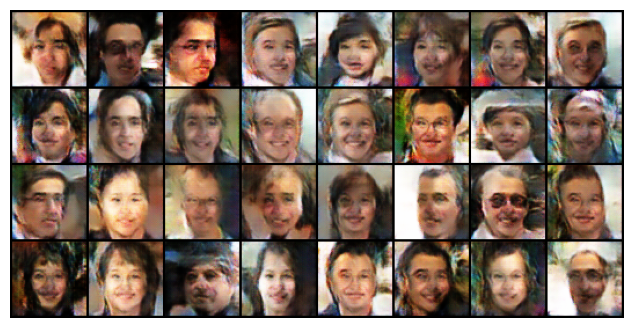

In [26]:
fake_img = gen(fixed_noise).detach().cpu()

fake_img_grid = torchvision.utils.make_grid(fake_img, normalize=True)

plt.figure(figsize=(14, 4))
plt.imshow(fake_img_grid.permute(1, 2, 0))
plt.axis("off")
plt.show()